<a href="https://colab.research.google.com/github/devdastl/EVA-8_Phase-1_Assignment-5/blob/main/EVA_assignment_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Clone assignemnt to setup python files
Here we will be cloning our repo and setting up correct directory such that this colab notebook can access our defined python classes.

In this way even if runtime deletes the data, we can again git clone it and by running below cell.

In [2]:
import os
!git clone https://github.com/devdastl/EVA-8_Phase-1_Assignment-5.git
os.chdir('EVA-8_Phase-1_Assignment-5')
!rm EVA_assignment-5.ipynb

Cloning into 'EVA-8_Phase-1_Assignment-5'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 25 (delta 7), reused 22 (delta 7), pack-reused 0
Unpacking objects: 100% (25/25), 9.22 KiB | 1.54 MiB/s, done.


## Import required libraries for pytorch
Cell to import python based libraries

In [3]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

##Data preperation
Here we are calling our custom Dataset class from `components/data.py` python file.
This class takes following arguments:
1. Dataset Name in `string` - Specify which dataset needs to be downloaded which are available in torchvision ex- 'MNIST', 'ImageNet'. For all supported dataset [view this](https://pytorch.org/vision/stable/datasets.html).
2. transforms - custom `Dataset` class takes transforms as arguments, you can specify `train_transform` and `test_transform` in `components/transform.py`.
3. train `bool` - this state either the dataset is for training or testing. Here we have two instance of `Dataset` one for train and other for test.
4. batch_size - custom `Dataset` class also has functionality to return dataloader as an attribute. Hence we can set batch size for that loader. 

In [4]:
from components.data import Dataset
from components.transform import train_transforms, test_transforms

my_mnist_train = Dataset('MNIST', transform=train_transforms, train=True, batch_size=64)
my_mnist_test = Dataset('MNIST', transform=test_transforms, train=False, batch_size=64)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



##Data visualization
visualization of the data we are working with:

torch.Size([64, 1, 28, 28])
torch.Size([64])


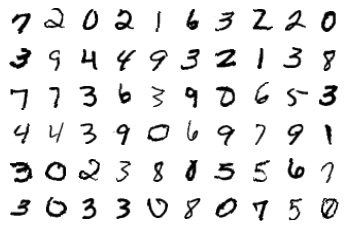

In [19]:
#my_mnist_train.dataloader returns a dataloader
dataiter = iter(my_mnist_train.dataloader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

##Model setup
Here we call our custom class Net() from `components/model.py` python file.
This file contains model architecture defination. Following are the arguments our custom `Net()` module takes:
1. in_channel - no. of channels of input image. For RGB it is 3 and for grayscale it is 1.
2. norm_type - Here we decide what kind of normalization is required in the model architecture. 
  - `"batch"` for performing batch normalization.
  - `"group"` for perfroming group normalization.
  - `"layer"` for performing layer normalization.

  more information on normalization type is in github README.
3. drop_out - rate at which you want to kill the neuron in each layer. `0.0` means no dropout.

Using this custom module here we are creating three model instance:
- `my_model1` for batch normalization.
- `my_model2` for group normalization.
- `my_model3` for layer normalization.

In [5]:
from components.model import Net
!pip install torchsummary
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

my_model1 = Net(in_channel=1, norm_type="batch", drop_out=0.0).to(device)
my_model2 = Net(in_channel=1, norm_type="group", drop_out=0.0).to(device)
my_model3 = Net(in_channel=1, norm_type="layer", drop_out=0.0).to(device)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cpu


### Layer normalization setup
We added elementwise-affine to False in layer-normalization layer to reduce the number of parameters.

In [6]:
#print model summary for all 3 models

print("-----------------------------------model arcitecture with Batch normalization and L1 regularization------------------------")
summary(my_model1, input_size=(1,28, 28))
print("-----------------------------------model arcitecture with Group normalization------------------------")
summary(my_model2, input_size=(1,28, 28))
print("-----------------------------------model arcitecture with layer normalization------------------------")
summary(my_model3, input_size=(1,28, 28))

-----------------------------------model arcitecture with Batch normalization and L1 regularization------------------------
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
           Dropout-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 12, 24, 24]           1,080
       BatchNorm2d-6           [-1, 12, 24, 24]              24
              ReLU-7           [-1, 12, 24, 24]               0
           Dropout-8           [-1, 12, 24, 24]               0
            Conv2d-9           [-1, 14, 22, 22]           1,512
      BatchNorm2d-10           [-1, 14, 22, 22]              28
             ReLU-11           [-1, 14, 22, 22]               0
          Dropout-12           [-1, 14, 22,

##Training model
Here we will going to train our three models. For this there are two more custom class modules which are responsible for training and testing.
1. `TrainModel` - This class contains source code to perform forward and backward pass and train the model.
2. `TestModel` - This class contains source code to test the model accuracy i.e. forward pass only.

In [7]:
# import our custom classes for training and testing model

from components.training import TrainModel
from components.test import TestModel
from torch.optim.lr_scheduler import StepLR 

EPOCHS = 20

In below cell, we are defining our model, optimizer, scheduler.
We are also defining instance of `TrainModel` and `TestModel` for all three model.
- `batch norm model` - my_model1, optimizer1, scheduler1, train_module1 and test_module1.
- `group norm model` - my_model2, optimizer2, scheduler2, train_module2 and test_module2.
- `layer norm model` - my_model3, optimizer3, scheduler3, train_module3 and test_module3.

Below are arguments for `TrainModel` instance:
1. model - model arcitecutre which will be trained.
2. device - device on which model will be trained i.e. cude, cpu, etc.
3. dataloader - dataloader which is attribute of `Dataset` class.
4. optimizer - optimizer to perform gredient decent.

In [9]:
# Training model with batch normalization and L1 regularization
my_model1 = Net(in_channel=1, norm_type="batch", drop_out=0.0).to(device)
optimizer1 = optim.SGD(my_model1.parameters(), lr=0.01, momentum=0.9)
scheduler1 = StepLR(optimizer1, step_size=4, gamma=0.1) 

train_module1 = TrainModel(my_model1, device, my_mnist_train.dataloader, optimizer1)
test_module1 = TestModel(my_model1, device, my_mnist_test.dataloader)


# Training model with group normalization
my_model2 = Net(in_channel=1, norm_type="group", drop_out=0.0).to(device)
optimizer2 = optim.SGD(my_model2.parameters(), lr=0.01, momentum=0.9)
scheduler2 = StepLR(optimizer2, step_size=4, gamma=0.1) 

train_module2 = TrainModel(my_model2, device, my_mnist_train.dataloader, optimizer2)
test_module2 = TestModel(my_model2, device, my_mnist_test.dataloader)


# Training model with Layer normalization
my_model3 = Net(in_channel=1, norm_type="layer", drop_out=0.0).to(device)
optimizer3 = optim.SGD(my_model3.parameters(), lr=0.01, momentum=0.9)
scheduler3 = StepLR(optimizer3, step_size=4, gamma=0.1) 

train_module3 = TrainModel(my_model3, device, my_mnist_train.dataloader, optimizer3)
test_module3 = TestModel(my_model3, device, my_mnist_test.dataloader)

####Epoch loop in training
Here we will start training of all model under one epoch.
To trigger training, we call `.train()` method on our `TrainModel` instance and `.test()` instance method on our `TestModel` instance.

`.train()` takes two arguments related to L1 regularization.
- L1_reg `bool` - if L1 regularization need to be performed while caculating loss.
- l1_lambda - Lambda value to control amount of L1 regularization. 



In [10]:
# Training model with Group normalization

for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    
    print("\n-----------training and testing loop for model1 (batch norm model)--------------")
    train_module1.train_a(L1_reg=True, l1_lambda=0.001) # batch norm model with L1 regularization.
    test_module1.test()
    scheduler1.step()

    print("\n-----------training and testing loop for model2 (group norm model)--------------")
    train_module2.train_a(L1_reg=False) 
    test_module2.test()
    scheduler2.step()

    print("\n-----------training and testing loop for model3 (layer norm model)--------------")
    train_module3.train_a(L1_reg=False) 
    test_module3.test()
    scheduler3.step()



EPOCH: 0
-----------training and testing loop for model1 (batch norm model)--------------


Loss=0.5698561668395996 Batch_id=937 Accuracy=90.06: 100%|██████████| 938/938 [01:14<00:00, 12.64it/s]



Test set: Average loss: 0.0906, Accuracy: 9752/10000 (97.52%)

-----------training and testing loop for model2 (group norm model)--------------


Loss=0.04811637103557587 Batch_id=937 Accuracy=85.77: 100%|██████████| 938/938 [01:10<00:00, 13.37it/s]



Test set: Average loss: 0.1187, Accuracy: 9677/10000 (96.77%)

-----------training and testing loop for model3 (layer norm model)--------------


Loss=0.12589530646800995 Batch_id=937 Accuracy=80.64: 100%|██████████| 938/938 [01:08<00:00, 13.75it/s]



Test set: Average loss: 0.1869, Accuracy: 9685/10000 (96.85%)

EPOCH: 1
-----------training and testing loop for model1 (batch norm model)--------------


Loss=0.47766318917274475 Batch_id=937 Accuracy=96.86: 100%|██████████| 938/938 [01:13<00:00, 12.75it/s]



Test set: Average loss: 0.1191, Accuracy: 9632/10000 (96.32%)

-----------training and testing loop for model2 (group norm model)--------------


Loss=0.09535504877567291 Batch_id=937 Accuracy=97.47: 100%|██████████| 938/938 [01:09<00:00, 13.55it/s]



Test set: Average loss: 0.0593, Accuracy: 9809/10000 (98.09%)

-----------training and testing loop for model3 (layer norm model)--------------


Loss=0.14662183821201324 Batch_id=937 Accuracy=96.19: 100%|██████████| 938/938 [01:08<00:00, 13.68it/s]



Test set: Average loss: 0.1570, Accuracy: 9632/10000 (96.32%)

EPOCH: 2
-----------training and testing loop for model1 (batch norm model)--------------


Loss=0.3181896209716797 Batch_id=937 Accuracy=97.25: 100%|██████████| 938/938 [01:13<00:00, 12.82it/s]



Test set: Average loss: 0.0992, Accuracy: 9686/10000 (96.86%)

-----------training and testing loop for model2 (group norm model)--------------


Loss=0.056592926383018494 Batch_id=937 Accuracy=97.98: 100%|██████████| 938/938 [01:09<00:00, 13.55it/s]



Test set: Average loss: 0.0499, Accuracy: 9853/10000 (98.53%)

-----------training and testing loop for model3 (layer norm model)--------------


Loss=0.04731164872646332 Batch_id=937 Accuracy=97.23: 100%|██████████| 938/938 [01:07<00:00, 13.81it/s]



Test set: Average loss: 0.0956, Accuracy: 9761/10000 (97.61%)

EPOCH: 3
-----------training and testing loop for model1 (batch norm model)--------------


Loss=0.35704585909843445 Batch_id=937 Accuracy=97.29: 100%|██████████| 938/938 [01:13<00:00, 12.80it/s]



Test set: Average loss: 0.0894, Accuracy: 9727/10000 (97.27%)

-----------training and testing loop for model2 (group norm model)--------------


Loss=0.16915397346019745 Batch_id=937 Accuracy=98.39: 100%|██████████| 938/938 [01:10<00:00, 13.39it/s]



Test set: Average loss: 0.0423, Accuracy: 9880/10000 (98.80%)

-----------training and testing loop for model3 (layer norm model)--------------


Loss=0.1250283271074295 Batch_id=937 Accuracy=97.77: 100%|██████████| 938/938 [01:08<00:00, 13.72it/s]



Test set: Average loss: 0.0676, Accuracy: 9845/10000 (98.45%)

EPOCH: 4
-----------training and testing loop for model1 (batch norm model)--------------


Loss=0.2821517288684845 Batch_id=937 Accuracy=98.60: 100%|██████████| 938/938 [01:14<00:00, 12.61it/s]



Test set: Average loss: 0.0310, Accuracy: 9908/10000 (99.08%)

-----------training and testing loop for model2 (group norm model)--------------


Loss=0.23461364209651947 Batch_id=937 Accuracy=98.93: 100%|██████████| 938/938 [01:10<00:00, 13.32it/s]



Test set: Average loss: 0.0293, Accuracy: 9922/10000 (99.22%)

-----------training and testing loop for model3 (layer norm model)--------------


Loss=0.09640240669250488 Batch_id=937 Accuracy=98.49: 100%|██████████| 938/938 [01:08<00:00, 13.63it/s]



Test set: Average loss: 0.0509, Accuracy: 9894/10000 (98.94%)

EPOCH: 5
-----------training and testing loop for model1 (batch norm model)--------------


Loss=0.28145700693130493 Batch_id=937 Accuracy=98.71: 100%|██████████| 938/938 [01:14<00:00, 12.52it/s]



Test set: Average loss: 0.0330, Accuracy: 9898/10000 (98.98%)

-----------training and testing loop for model2 (group norm model)--------------


Loss=0.03752858564257622 Batch_id=937 Accuracy=99.06: 100%|██████████| 938/938 [01:09<00:00, 13.57it/s]



Test set: Average loss: 0.0280, Accuracy: 9929/10000 (99.29%)

-----------training and testing loop for model3 (layer norm model)--------------


Loss=0.06719181686639786 Batch_id=937 Accuracy=98.66: 100%|██████████| 938/938 [01:08<00:00, 13.68it/s]



Test set: Average loss: 0.0487, Accuracy: 9898/10000 (98.98%)

EPOCH: 6
-----------training and testing loop for model1 (batch norm model)--------------


Loss=0.22374804317951202 Batch_id=937 Accuracy=98.71: 100%|██████████| 938/938 [01:13<00:00, 12.81it/s]



Test set: Average loss: 0.0354, Accuracy: 9894/10000 (98.94%)

-----------training and testing loop for model2 (group norm model)--------------


Loss=0.00940684787929058 Batch_id=937 Accuracy=99.07: 100%|██████████| 938/938 [01:09<00:00, 13.51it/s]



Test set: Average loss: 0.0272, Accuracy: 9928/10000 (99.28%)

-----------training and testing loop for model3 (layer norm model)--------------


Loss=0.03605250269174576 Batch_id=937 Accuracy=98.64: 100%|██████████| 938/938 [01:09<00:00, 13.59it/s]



Test set: Average loss: 0.0477, Accuracy: 9897/10000 (98.97%)

EPOCH: 7
-----------training and testing loop for model1 (batch norm model)--------------


Loss=0.24352149665355682 Batch_id=937 Accuracy=98.61: 100%|██████████| 938/938 [01:15<00:00, 12.43it/s]



Test set: Average loss: 0.0322, Accuracy: 9899/10000 (98.99%)

-----------training and testing loop for model2 (group norm model)--------------


Loss=0.020863357931375504 Batch_id=937 Accuracy=99.08: 100%|██████████| 938/938 [01:11<00:00, 13.04it/s]



Test set: Average loss: 0.0269, Accuracy: 9925/10000 (99.25%)

-----------training and testing loop for model3 (layer norm model)--------------


Loss=0.06167348474264145 Batch_id=937 Accuracy=98.70: 100%|██████████| 938/938 [01:09<00:00, 13.45it/s]



Test set: Average loss: 0.0464, Accuracy: 9902/10000 (99.02%)

EPOCH: 8
-----------training and testing loop for model1 (batch norm model)--------------


Loss=0.3649038076400757 Batch_id=937 Accuracy=98.89: 100%|██████████| 938/938 [01:16<00:00, 12.33it/s]



Test set: Average loss: 0.0277, Accuracy: 9913/10000 (99.13%)

-----------training and testing loop for model2 (group norm model)--------------


Loss=0.07328858226537704 Batch_id=937 Accuracy=99.17: 100%|██████████| 938/938 [01:10<00:00, 13.24it/s]



Test set: Average loss: 0.0267, Accuracy: 9929/10000 (99.29%)

-----------training and testing loop for model3 (layer norm model)--------------


Loss=0.05597031116485596 Batch_id=937 Accuracy=98.76: 100%|██████████| 938/938 [01:10<00:00, 13.37it/s]



Test set: Average loss: 0.0459, Accuracy: 9903/10000 (99.03%)

EPOCH: 9
-----------training and testing loop for model1 (batch norm model)--------------


Loss=0.26369261741638184 Batch_id=937 Accuracy=98.93: 100%|██████████| 938/938 [01:15<00:00, 12.45it/s]



Test set: Average loss: 0.0286, Accuracy: 9912/10000 (99.12%)

-----------training and testing loop for model2 (group norm model)--------------


Loss=0.012754063121974468 Batch_id=937 Accuracy=99.19: 100%|██████████| 938/938 [01:12<00:00, 12.96it/s]



Test set: Average loss: 0.0265, Accuracy: 9931/10000 (99.31%)

-----------training and testing loop for model3 (layer norm model)--------------


Loss=0.05356350168585777 Batch_id=937 Accuracy=98.78: 100%|██████████| 938/938 [01:11<00:00, 13.08it/s]



Test set: Average loss: 0.0457, Accuracy: 9902/10000 (99.02%)

EPOCH: 10
-----------training and testing loop for model1 (batch norm model)--------------


Loss=0.22781407833099365 Batch_id=937 Accuracy=98.89: 100%|██████████| 938/938 [01:15<00:00, 12.38it/s]



Test set: Average loss: 0.0273, Accuracy: 9920/10000 (99.20%)

-----------training and testing loop for model2 (group norm model)--------------


Loss=0.010055875405669212 Batch_id=937 Accuracy=99.17: 100%|██████████| 938/938 [01:12<00:00, 12.87it/s]



Test set: Average loss: 0.0267, Accuracy: 9927/10000 (99.27%)

-----------training and testing loop for model3 (layer norm model)--------------


Loss=0.028850100934505463 Batch_id=937 Accuracy=98.72: 100%|██████████| 938/938 [01:10<00:00, 13.22it/s]



Test set: Average loss: 0.0459, Accuracy: 9903/10000 (99.03%)

EPOCH: 11
-----------training and testing loop for model1 (batch norm model)--------------


Loss=0.21908828616142273 Batch_id=937 Accuracy=98.95: 100%|██████████| 938/938 [01:15<00:00, 12.48it/s]



Test set: Average loss: 0.0269, Accuracy: 9920/10000 (99.20%)

-----------training and testing loop for model2 (group norm model)--------------


Loss=0.015096691437065601 Batch_id=937 Accuracy=99.22: 100%|██████████| 938/938 [01:12<00:00, 12.99it/s]



Test set: Average loss: 0.0266, Accuracy: 9930/10000 (99.30%)

-----------training and testing loop for model3 (layer norm model)--------------


Loss=0.03800392523407936 Batch_id=937 Accuracy=98.75: 100%|██████████| 938/938 [01:10<00:00, 13.37it/s]



Test set: Average loss: 0.0453, Accuracy: 9903/10000 (99.03%)

EPOCH: 12
-----------training and testing loop for model1 (batch norm model)--------------


Loss=0.2348853200674057 Batch_id=937 Accuracy=98.97: 100%|██████████| 938/938 [01:16<00:00, 12.31it/s]



Test set: Average loss: 0.0272, Accuracy: 9919/10000 (99.19%)

-----------training and testing loop for model2 (group norm model)--------------


Loss=0.08638447523117065 Batch_id=937 Accuracy=99.18: 100%|██████████| 938/938 [01:13<00:00, 12.71it/s]



Test set: Average loss: 0.0266, Accuracy: 9930/10000 (99.30%)

-----------training and testing loop for model3 (layer norm model)--------------


Loss=0.16595886647701263 Batch_id=937 Accuracy=98.79: 100%|██████████| 938/938 [01:14<00:00, 12.52it/s]



Test set: Average loss: 0.0454, Accuracy: 9901/10000 (99.01%)

EPOCH: 13
-----------training and testing loop for model1 (batch norm model)--------------


Loss=0.4130670726299286 Batch_id=937 Accuracy=99.02: 100%|██████████| 938/938 [01:23<00:00, 11.29it/s]



Test set: Average loss: 0.0271, Accuracy: 9919/10000 (99.19%)

-----------training and testing loop for model2 (group norm model)--------------


Loss=0.011284997686743736 Batch_id=937 Accuracy=99.17: 100%|██████████| 938/938 [01:20<00:00, 11.59it/s]



Test set: Average loss: 0.0266, Accuracy: 9930/10000 (99.30%)

-----------training and testing loop for model3 (layer norm model)--------------


Loss=0.03032495081424713 Batch_id=937 Accuracy=98.83: 100%|██████████| 938/938 [01:15<00:00, 12.45it/s]



Test set: Average loss: 0.0455, Accuracy: 9902/10000 (99.02%)

EPOCH: 14
-----------training and testing loop for model1 (batch norm model)--------------


Loss=0.22751903533935547 Batch_id=937 Accuracy=98.95: 100%|██████████| 938/938 [01:19<00:00, 11.85it/s]



Test set: Average loss: 0.0270, Accuracy: 9919/10000 (99.19%)

-----------training and testing loop for model2 (group norm model)--------------


Loss=0.0025106517132371664 Batch_id=937 Accuracy=99.14: 100%|██████████| 938/938 [01:15<00:00, 12.41it/s]



Test set: Average loss: 0.0265, Accuracy: 9931/10000 (99.31%)

-----------training and testing loop for model3 (layer norm model)--------------


Loss=0.024305878207087517 Batch_id=937 Accuracy=98.80: 100%|██████████| 938/938 [01:12<00:00, 12.93it/s]



Test set: Average loss: 0.0454, Accuracy: 9903/10000 (99.03%)

EPOCH: 15
-----------training and testing loop for model1 (batch norm model)--------------


Loss=0.21536383032798767 Batch_id=937 Accuracy=99.00: 100%|██████████| 938/938 [01:17<00:00, 12.07it/s]



Test set: Average loss: 0.0264, Accuracy: 9924/10000 (99.24%)

-----------training and testing loop for model2 (group norm model)--------------


Loss=0.005994219798594713 Batch_id=937 Accuracy=99.19: 100%|██████████| 938/938 [01:12<00:00, 12.86it/s]



Test set: Average loss: 0.0265, Accuracy: 9930/10000 (99.30%)

-----------training and testing loop for model3 (layer norm model)--------------


Loss=0.053596604615449905 Batch_id=937 Accuracy=98.79: 100%|██████████| 938/938 [01:12<00:00, 12.90it/s]



Test set: Average loss: 0.0454, Accuracy: 9901/10000 (99.01%)

EPOCH: 16
-----------training and testing loop for model1 (batch norm model)--------------


Loss=0.21677598357200623 Batch_id=937 Accuracy=98.96: 100%|██████████| 938/938 [01:16<00:00, 12.26it/s]



Test set: Average loss: 0.0266, Accuracy: 9923/10000 (99.23%)

-----------training and testing loop for model2 (group norm model)--------------


Loss=0.08826892822980881 Batch_id=937 Accuracy=99.15: 100%|██████████| 938/938 [01:12<00:00, 12.96it/s]



Test set: Average loss: 0.0265, Accuracy: 9930/10000 (99.30%)

-----------training and testing loop for model3 (layer norm model)--------------


Loss=0.08839984238147736 Batch_id=937 Accuracy=98.83: 100%|██████████| 938/938 [01:11<00:00, 13.19it/s]



Test set: Average loss: 0.0454, Accuracy: 9901/10000 (99.01%)

EPOCH: 17
-----------training and testing loop for model1 (batch norm model)--------------


Loss=0.21628347039222717 Batch_id=937 Accuracy=98.93: 100%|██████████| 938/938 [01:16<00:00, 12.30it/s]



Test set: Average loss: 0.0267, Accuracy: 9920/10000 (99.20%)

-----------training and testing loop for model2 (group norm model)--------------


Loss=0.007726202253252268 Batch_id=937 Accuracy=99.15: 100%|██████████| 938/938 [01:13<00:00, 12.77it/s]



Test set: Average loss: 0.0265, Accuracy: 9930/10000 (99.30%)

-----------training and testing loop for model3 (layer norm model)--------------


Loss=0.0870572179555893 Batch_id=937 Accuracy=98.76: 100%|██████████| 938/938 [01:12<00:00, 13.01it/s]



Test set: Average loss: 0.0454, Accuracy: 9901/10000 (99.01%)

EPOCH: 18
-----------training and testing loop for model1 (batch norm model)--------------


Loss=0.2676035165786743 Batch_id=937 Accuracy=98.96: 100%|██████████| 938/938 [01:17<00:00, 12.16it/s]



Test set: Average loss: 0.0265, Accuracy: 9924/10000 (99.24%)

-----------training and testing loop for model2 (group norm model)--------------


Loss=0.0016096893232315779 Batch_id=937 Accuracy=99.18: 100%|██████████| 938/938 [01:12<00:00, 12.95it/s]



Test set: Average loss: 0.0265, Accuracy: 9930/10000 (99.30%)

-----------training and testing loop for model3 (layer norm model)--------------


Loss=0.06081075593829155 Batch_id=937 Accuracy=98.76: 100%|██████████| 938/938 [01:10<00:00, 13.22it/s]



Test set: Average loss: 0.0454, Accuracy: 9900/10000 (99.00%)

EPOCH: 19
-----------training and testing loop for model1 (batch norm model)--------------


Loss=0.3052992820739746 Batch_id=937 Accuracy=99.00: 100%|██████████| 938/938 [01:17<00:00, 12.08it/s]



Test set: Average loss: 0.0266, Accuracy: 9920/10000 (99.20%)

-----------training and testing loop for model2 (group norm model)--------------


Loss=0.07851974666118622 Batch_id=937 Accuracy=99.19: 100%|██████████| 938/938 [01:12<00:00, 12.87it/s]



Test set: Average loss: 0.0265, Accuracy: 9930/10000 (99.30%)

-----------training and testing loop for model3 (layer norm model)--------------


Loss=0.013152443803846836 Batch_id=937 Accuracy=98.80: 100%|██████████| 938/938 [01:12<00:00, 12.92it/s]



Test set: Average loss: 0.0454, Accuracy: 9900/10000 (99.00%)



##Accuracy and loss visualization of three models
Now we will use our `plot_util.py` file under `components/` to plot our models accuracy and loss against total test samples performed.
<br>
our test losses and accuracy will be stored in our TestModule instances i.e.:
- losses and accuracy of **Batch Norm** model in `test_module1.test_losses` and `test_module1.test_acc`
- losses and accuracy of **Group Norm** model in `test_module2`
- losses and accuracy of **Layer Norm** model in `test_module3`

plot function `plot_loss_accuracy` will take this instances of `TestModule` and will extract and plot two graphs.
1. loss VS iteration for all thress model.
2. Accuracy VS iteration for all three model.

#####Model 1 -> batch norm model
#####Model 2 -> group norm model
#####Model 3 -> layer norm model

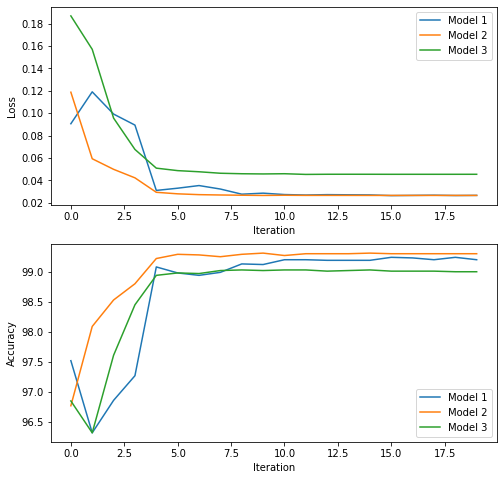

In [11]:
from components.plot_util import plot_loss_accuracy

%matplotlib inline
plot_loss_accuracy(test_module1, test_module2, test_module3)

##Get misclassification for all three model.
Here we have three cells, each cell will plot misclassified images, there correct label and predicted label.
- we are ploting 10 images for each model in 5x2 matrix.
- this images and labels are saved inside instance of `TestModule`. we can use attributes `.test_misc_img` and `.test_misc_label` to get misclassified test images and labels resp.

we are using `plot_misclassified()` function which takes following arguments.
- `test_misc_img` attribute of `TestModule` instance of respective model i.e. `test_module1.test_misc_img`. it contains misclassified image.
- `test_misc_label` attribute of `TestModule` instance of respective model i.e. `test_module1.test_misc_label`. it contains misclassified label.
- `string`, it is the title for the graph. Graph will also be saved inside `report/` dir with this title name.

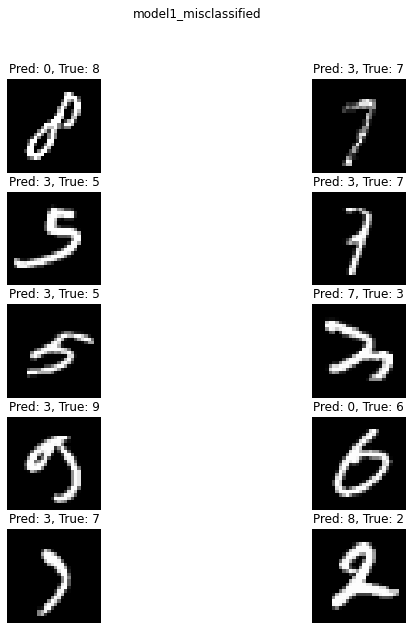

In [13]:
from components.plot_util import plot_misclassified

# misclassification from model1 i.e. Batch norm model
%matplotlib inline
plot_misclassified(test_module1.test_misc_img, test_module1.test_misc_label, 'model1_misclassified')

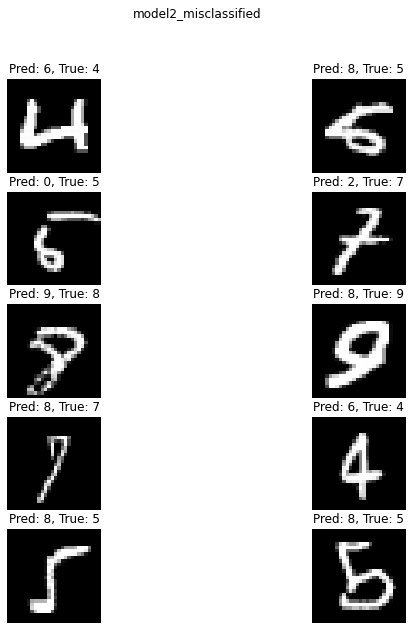

In [14]:
# misclassification from model2 i.e. Group norm model
%matplotlib inline
plot_misclassified(test_module2.test_misc_img, test_module2.test_misc_label, 'model2_misclassified')

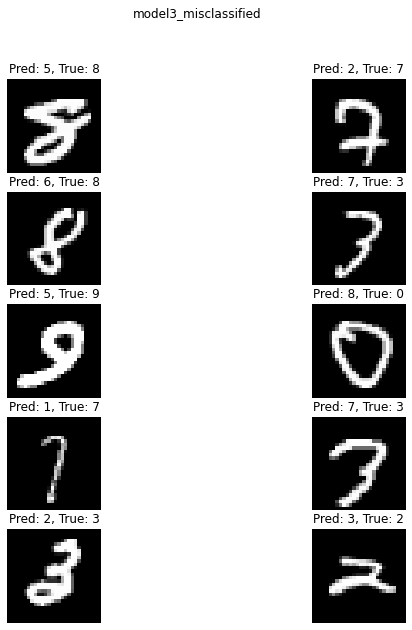

In [15]:
# misclassification from model3 i.e. Layer norm model
%matplotlib inline
plot_misclassified(test_module3.test_misc_img, test_module3.test_misc_label, 'model3_misclassified')